## Piecewise constant 1D DG, no projection step for Traffic Flow with LLF Flux, time-stepping with AB2+FE

##### Considering the traffic flow model:

   #### $\frac{\partial}{\partial t} u + \frac{\partial}{\partial x} (u(1-u)) = \frac{\partial}{\partial t} u + \frac{\partial f(u)}{\partial x} = 0 $  &emsp; (1)
with fixed boundary conditions.

##### The following must be done:
- Spatial discretization with piecewise constant DG
- Determine LLF Flux for Trafflic flow
- AB2+FE Time stepping

### Spatial Discretization
#### Weak Formulation

We require the weak formulation of (1), obtained by multiplying by a test function and integrating by parts

$$ \int_\Omega \frac{\partial u}{\partial t}v\ dx+\int_\Omega v \frac{\partial f(u)}{\partial x}\ dx = \int_\Omega \frac{\partial u}{\partial t}v\ dx - \int_\Omega \frac{\partial v}{\partial x} f(u)\ dx + \left. f(u)v \right|_{\partial\Omega} = 0 $$

Integrating by parts once more and expanding the boundary terms gives
$$\boxed{ (\partial_t u, v)_\Omega + (\partial_x f(u), v)_\Omega + v(\tilde{f}(u_i,u_e)-f(u_i))|_{\partial\Omega} = 0 }$$

Where $u_i$ is the cell value, $u_e$ is the adjacent cell value, and $\tilde{f}(u_i,u_e)$ is the incoming flux determined numerically. The inner products denote integrals of the product of the functions.

#### Piecewise Constant DG
First discretizing in the spatial variable $x$, letting $\Omega_j = (x_{j-1/2}, x_{j+1/2})$, and $\Omega = \cup_j\Omega_j$ be a partition of the real line. Call $\Delta x_j = x_{j+1/2}-x_{j-1/2}$, and $h = \sup_j\Delta x_j$.

The finite dimensional space $V^h$ that the approximate solution $u^h(t)$ belongs to for $t\in[0,T]$ is chosen to be 
$$ V^h = \left\{ v : v|_{\Omega_j}\in P_0(\Omega_j) \right\} $$
where $P_0$ is the space of order zero polynomials, i.e. constant. We define $v$ outside of $\Omega_j$ to be zero.

Then, the discontinuous Galerkin formulation provides each cell $\Omega_j$ with a corresponding weak form (using inner product notation)
$$ (\partial_t u,v)_{\Omega_j} + (\partial_xf(u), v)_{\Omega_j} + v(\tilde{f}(u_i,u_e)-f(u_i))|_{\partial\Omega_j} = 0 $$

Noting that the basis of $V^h$ is simply $1$, the approximate solution in a given cell is $u^h = u^h_j\in\mathbb{R}$, and $f(u^h) = f^h_j\in\mathbb{R}$, the second term disappears and we have

$$\boxed{ \partial_t u^h_j = \frac{1}{\Delta x_j}\left[\tilde{f}(u^h_{j-1},u^h_{j}) - \tilde{f}(u^h_j,u^h_{j+1}) \right] }$$

### Choosing the Numerical Flux $\tilde{f}$
Using a standard Roe-splitting for the flux, we have
$$ \tilde{f}(u_i,u_e) = \frac{1}{2}\left( (f(u_e)+f(u_i)) - R|\Lambda|L(u_e-u_i) \right) $$
where the Jacobian of $f$ is written in terms of its left and right eigenvectors, $\mathbb{J}(f) = R\Lambda L$.

For Traffic flow, with $f(u) = u(1-u) = u-u^2$, we have $\mathbb{J} = 1-2u$, meaning the eigenvalue is indeed $1-2u$, and the left and right eigenvectors are $1$. Hence, we take the flux
$$\boxed{ \tilde{f}(u_i,u_e) = \frac{1}{2}\left( f(u_e)+f(u_i) - \alpha(u_e-u_i) \right) }$$
where $\alpha(u_i,u_e) = \max (|1-2u_i|, |1-2u_e|)$

### AB2+FE Time Stepping
To timestep an equation of the form $\partial_t u = L(u)$, the Second-order Adams Bashforth Method is used, that is
$$ \boxed{u^{n+1} = u^n + \frac{\Delta t}{2}\left( 3L(u^n) - L(u^{n-1}) \right) }$$
Which is a 2-step method, and hence requires a single second order step, which can be done with a single Forward Euler step
$$ u^1 = u^0 + \Delta tL(u^0) $$

### Implementation
Consider a uniform grid with points at $x_j = j\Delta x$, with $j=-1,...,N+1$, and $\Delta x = 1/N$, with $N$ the number of cells centered at each $x_j$. The cells centered at $-\Delta x, 1+\Delta x$ are ghost-cells, meaning $u(-\Delta x) = u_{-1} = u(1) = u_N$ and $u(1+\Delta x) = u_{N+1} = u(0) = u_0$. This gives $N+1$ interior cells, and $N+3$ total cells.

Note that since python indexing starts from 0, and not -1, the subscript should run from 0 to N+2.

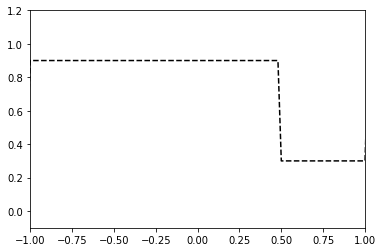

In [52]:
# Imports
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from domain import Mesh, Cell1d

#### Parameters, Trafflic Flow Flux, and Initial Condition
L = 1
h = 0.02  # The cell size
dt = h/2 # Time-step size
T = 1 # Final time starting from 0

def f(u): # Traffic flow flux function
    return u*(1-u)

def J(u): # Traffic flow flux Jacobian
    return 1-2*u

def IC(x): # Initial Condition
    if x < 0.5:
        return 0.9
    return 0.3

### Spatial Discretization
N = int(2*L/h)
x = np.linspace(-L-h,L+h,N+3)
msh = Mesh(1, [Cell1d(xi, h, f) for xi in x])
msh.impose_IC(IC)
msh.impose_periodic_BC()

# Plot Initial Condition
fig, ax = plt.subplots()

line, = ax.plot(msh.x, msh.u,'--k')
ax.set_xlim([-L,L])
ax.set_ylim([-0.1,1.2])
plt.show()

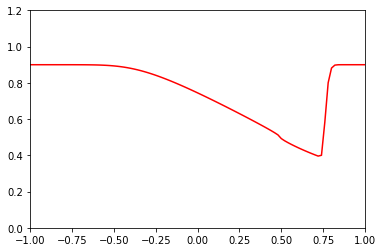

In [53]:
### Time stepping
def ab2(u,Ln1,Ln0): # 2nd Order Adams-Bashforth
    return u + 0.5*dt*(3*Ln1-Ln0)

def fe(u,Ln0): # Forward Euler
    return u + dt*Ln0

# Initial Time step so that AB2 can be used
for j in range(1,N+2):
    cell = msh.cells[j]
    cellL = msh.cells[j-1]
    cellR = msh.cells[j+1]
    cell.L0 = (cellL.numflux(cell, J) - cell.numflux(cellR, J))/h
    cell.u = fe(cell.u,cell.L0)
msh.impose_periodic_BC()
msh.retrieve_u()


t = dt
while t < T:
    clear_output(wait=True)
    t += dt
    for j in range(1,N+2):
        cell = msh.cells[j]
        cellL = msh.cells[j-1]
        cellR = msh.cells[j+1]
        cell.L1 = (cellL.numflux(cell, J) - cell.numflux(cellR, J))/h
        u1 = ab2(cell.u,cell.L1,cell.L0)
        cell.L0 = cell.L1
        cell.u = u1
    msh.impose_periodic_BC()
    msh.retrieve_u()
    
plt.plot(msh.x, msh.u,'-r')
plt.xlim([-L,L])
plt.ylim([0,1.2])
plt.show()